## Data Retrieval

We are getting the Excel spreadsheets from the LA Metro data archive that has historical ridership data that includes a breakdown of every single LA Metro station, along with getting the shape files for census tracts in Los Angeles

In [0]:
!wget -Nq http://libraryarchives.metro.net/DPGTL/Ridership/RailActivityByStationFY2017.xlsx
!wget -Nq http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_TRACTS_2010.zip
!unzip -o CENSUS_TRACTS_2010.zip
!ls -lah

Archive:  CENSUS_TRACTS_2010.zip
  inflating: CENSUS_TRACTS_2010.cpg  
  inflating: CENSUS_TRACTS_2010.dbf  
  inflating: CENSUS_TRACTS_2010.prj  
  inflating: CENSUS_TRACTS_2010.sbn  
  inflating: CENSUS_TRACTS_2010.sbx  
  inflating: CENSUS_TRACTS_2010.shp  
  inflating: CENSUS_TRACTS_2010.shp.xml  
  inflating: CENSUS_TRACTS_2010.shx  
total 9.0M
drwxr-xr-x 1 root root 4.0K Apr 13 19:35 .
drwxr-xr-x 1 root root 4.0K Apr 13 19:34 ..
-rw-rw-rw- 1 root root    5 Jan 26  2016 CENSUS_TRACTS_2010.cpg
-rw-rw-rw- 1 root root 232K Jan 26  2016 CENSUS_TRACTS_2010.dbf
-rw-rw-rw- 1 root root  565 Jan 26  2016 CENSUS_TRACTS_2010.prj
-rw-rw-rw- 1 root root  23K Jan 26  2016 CENSUS_TRACTS_2010.sbn
-rw-rw-rw- 1 root root 1012 Jan 26  2016 CENSUS_TRACTS_2010.sbx
-rw-rw-rw- 1 root root 5.1M Jan 26  2016 CENSUS_TRACTS_2010.shp
-rw-rw-rw- 1 root root  48K Jan 26  2016 CENSUS_TRACTS_2010.shp.xml
-rw-rw-rw- 1 root root  19K Jan 26  2016 CENSUS_TRACTS_2010.shx
-rw-r--r-- 1 root root 3.5M Jan 26  2016 CENS

## Importing Packages in Python

Importing relevant packages in Python, such as Fiona and Shapely

Fiona and Shapely

In [0]:
!pip install fiona shapely

    100% |████████████████████████████████| 17.9MB 1.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


## Importing within Python

In [0]:
%matplotlib inline
import sys, os, time

import numpy as np
import pandas as pd
import math     
from math import sqrt, isnan

import matplotlib.pyplot as plt

import fiona
import shapely
import shapely.geometry
# import rtree
                                                                                                                                                                                      
from io import StringIO                                                                                                                                                                                     
xrange = range                                                                                                                                                                                              
from tokenize import generate_tokens 


Open LA census tracts using Fiona

## Reading LA metro ridership information from Excel
We extract the latitude and longtitude information for each metro station from the data. Right now we're interested in the geocoordinates of the metro station so that we can identify which census tracts are within a certain radius of each metro station.

In [0]:
# Creating dataframe from reading and parsing a sheet in excel
blue_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Blue Line")
# blue_ridership_df.head(10)
# Taking only the columns of interest (latitude and longitude)
blue_ridership_df_geocoord = blue_ridership_df[['Latitude', 'Longitude']]
# Printing out the first 20 elements
blue_ridership_df_geocoord.head(20)

red_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Red Line")
# red_ridership_df.head(10)
red_ridership_df_geocoord = red_ridership_df[['Latitude', 'Longitude']]
red_ridership_df_geocoord.head(20)

expo_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Expo Line")
# expo_ridership_df.head(10)
expo_ridership_df_geocoord = expo_ridership_df[['Latitude', 'Longitude']]
expo_ridership_df_geocoord.head(20)

green_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Green Line")
# green_ridership_df.head(10)
green_ridership_df_geocoord = green_ridership_df[['Latitude', 'Longitude']]
green_ridership_df_geocoord.head(20)
green_ridership_df[['Average_Daily_Boardings']].head(20)

gold_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Gold Line")

purple_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Purple Line")


Visualizing the Metro Data

Text(0.5, 1.0, 'Blue Line Ridership Breakdown')

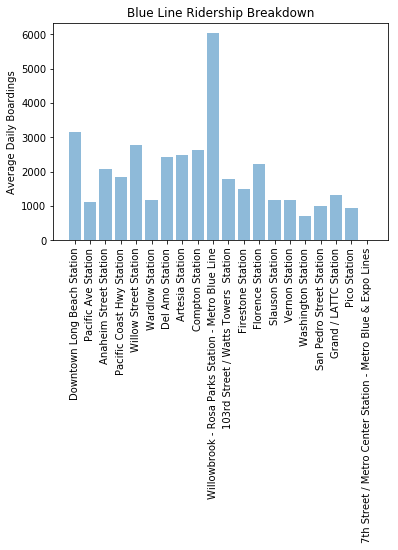

In [0]:
y_pos = np.arange(len(blue_ridership_df[0:20][["Station"]]))
stations = np.array(blue_ridership_df[0:20][["Station"]]).flatten()
boardings = np.array(blue_ridership_df[0:20][["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Blue Line Ridership Breakdown")


Collecting the dataframes from different lines and storing them into one list

In [0]:
line_ridership_df_list_17 = [blue_ridership_df, red_ridership_df, expo_ridership_df,
                      green_ridership_df, gold_ridership_df, purple_ridership_df]

line_ridership_list_aggregated = []

for line_df in line_ridership_df_list_17:
  line_ridership_aggregated = {}
  invalid_row_indicies = []
  for i in range(len(line_df.index)):
    daily_boardings = line_df.loc[i]['Average_Daily_Boardings']
    daytype = line_df.loc[i]['Daytype']
    
    if type(line_df.loc[i]['Station']) is not str:
      invalid_row_indicies.append(i)
      
    elif daily_boardings == 0 or isnan(daily_boardings):
      invalid_row_indicies.append(i)
      
    elif daytype != "Weekday":
      invalid_row_indicies.append(i)
      
    else:
      station = line_df.loc[i]['Station']
      lat = line_df.loc[i]['Latitude']
      lon = line_df.loc[i]['Longitude']
      
      if station in line_ridership_aggregated:
        line_ridership_aggregated[station]['daily_boardings'] += daily_boardings
      
      else:
        value = {'daily_boardings': daily_boardings, 'lat': lat, 'lon': lon}
        line_ridership_aggregated[station] = value
         
  line_df.drop(invalid_row_indicies, inplace=True)
  line_ridership_list_aggregated.append(line_ridership_aggregated)
  print(line_ridership_aggregated)
 
  

{'Downtown Long Beach Station': {'daily_boardings': 3165.275984433229, 'lat': 33.768071, 'lon': -118.192921}, 'Pacific Ave Station': {'daily_boardings': 1123.8540494658018, 'lat': 33.772258, 'lon': -118.1937}, 'Anaheim Street Station': {'daily_boardings': 2508.8023222847514, 'lat': 33.78183, 'lon': -118.189384}, 'Pacific Coast Hwy Station': {'daily_boardings': 2493.337958156897, 'lat': 33.78909, 'lon': -118.189382}, 'Willow Street Station': {'daily_boardings': 3887.0798860619743, 'lat': 33.807079, 'lon': -118.189834}, 'Wardlow Station': {'daily_boardings': 1562.9475960265388, 'lat': 33.819865, 'lon': -118.19609}, 'Del Amo Station': {'daily_boardings': 3116.437970001799, 'lat': 33.848222, 'lon': -118.211017}, 'Artesia Station': {'daily_boardings': 3342.715522376607, 'lat': 33.876082, 'lon': -118.222503}, 'Compton Station': {'daily_boardings': 3740.821724419464, 'lat': 33.89749, 'lon': -118.224249}, 'Willowbrook - Rosa Parks Station - Metro Blue Line': {'daily_boardings': 10197.994696967

Visualizing ridership breakdown for each row!

Text(0.5, 1.0, 'Red Line Ridership Breakdown')

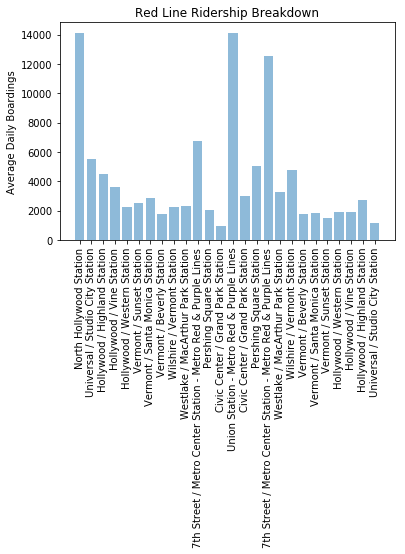

In [0]:
y_pos = np.arange(len(red_ridership_df[["Station"]]))
stations = np.array(red_ridership_df[["Station"]]).flatten()
boardings = np.array(red_ridership_df[["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Red Line Ridership Breakdown")

Text(0.5, 1.0, 'Expo Line Ridership Breakdown')

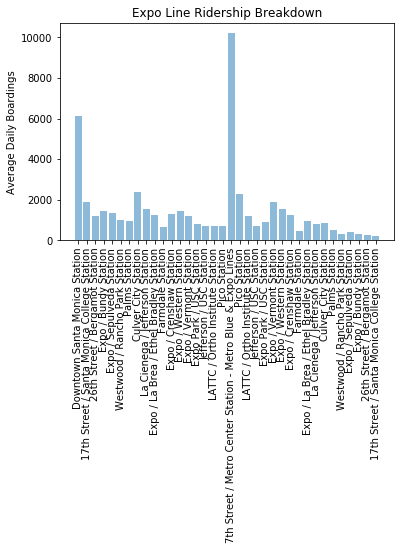

In [0]:
y_pos = np.arange(len(expo_ridership_df[["Station"]]))
stations = np.array(expo_ridership_df[["Station"]]).flatten()
boardings = np.array(expo_ridership_df[["Average_Daily_Boardings"]].values).flatten()

plt.bar(y_pos, boardings, align='center', alpha=0.5)
plt.xticks(y_pos, stations)
plt.xticks(rotation='vertical')
plt.ylabel("Average Daily Boardings")
plt.title("Expo Line Ridership Breakdown")

By looking at the data, we can observe that some rows have empty values for stations and zero/NaN values for daily boardings. To clean up our data, we want to remove these rows from our dataframes. Here is a function that helps us with the removal.

In [0]:
def invalid_rows_to_remove(df):
  invalid_row_indicies = []
  for i in range(len(df.index)):
    station = df.loc[i]['Station']
    daily_boardings = df.loc[i]['Daily Boardings']
    if type(station) is not str:
      invalid_row_indicies.append(i)
  
    elif daily_boardings == 0 or isnan(daily_boardings):
      invalid_row_indicies.append(i)
  
  return invalid_row_indicies

# Shapefile and Census data mapped across tracts

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os
os.listdir("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/")

['tl_2018_06_tract.shx',
 'tl_2018_06_tract.prj',
 'tl_2018_06_tract.shp.iso.xml',
 'tl_2018_06_tract.cpg',
 'tl_2018_06_tract.dbf',
 'tl_2018_06_tract.shp.ea.iso.xml',
 'tl_2018_06_tract.shp']

Looking at the properties of census tracts we are interested in

In [0]:
                                                                                                                                                                          
# open shapefile with fiona                                                                                                                                                                                 
with fiona.open("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/tl_2018_06_tract.shp", "r") as f:                                                                                                                                         
      # get first item in shape iterator                                                                                                                                                                    
      it = iter(f)                                                                                                                                                                                          
      example_data = next(it)                                                                                                                                                                               
      print("fiona parsed us an object of type:", type(example_data))                                                                                                                                       
                                                                                                                                                                                                            
print("Keys specifying shape info", example_data.keys())                                                                                                                                                    
                                                                                                                                                                                                            
print("keys:", example_data["geometry"].keys())                                                                                                                                                             
print("coordinates:", example_data["geometry"]["coordinates"])                                                                                                                                              
max_coord = max(example_data["geometry"]["coordinates"])                                                                                                                                                    
min_coord = min(example_data["geometry"]["coordinates"])                                                                                                                                                    
                                                                                                                                                                                                            
print("type:", example_data["geometry"]["type"])                                                                                                                                                            
                                                                                                                                                                                                            
print("keys:", example_data["properties"].keys())                                                                                                                                                           
for k in example_data["properties"].keys():                                                                                                                                                                 
      print(example_data["properties"][k])                                                                                                                                                                  
                                                                                                                                                                                                            
print("geoid:", example_data["properties"]["GEOID"])                                                                                                                                                        


fiona parsed us an object of type: <class 'dict'>
Keys specifying shape info dict_keys(['type', 'id', 'properties', 'geometry'])
keys: dict_keys(['type', 'coordinates'])
coordinates: [[(-118.581186, 34.143176), (-118.580994, 34.143341), (-118.580899, 34.143571), (-118.580927, 34.143786), (-118.580891, 34.144047), (-118.58094, 34.14423), (-118.580847, 34.14443), (-118.580915, 34.144628), (-118.580912, 34.144997), (-118.580214, 34.145547), (-118.580124, 34.145652999999996), (-118.580072, 34.145738), (-118.580036, 34.145829), (-118.580018, 34.145922999999996), (-118.580013, 34.146277999999995), (-118.579994, 34.147815), (-118.579988, 34.148282), (-118.57996800000001, 34.149885999999995), (-118.579955, 34.150079999999996), (-118.57983300000001, 34.151289), (-118.579702, 34.152585), (-118.579639, 34.153175), (-118.579521, 34.154343), (-118.579411, 34.155438), (-118.579311, 34.156435), (-118.579205, 34.157481), (-118.577684, 34.157498), (-118.577584, 34.157508), (-118.577427, 34.157536), (-1

Since we're interested only in census tracts in LA county, we will check each census tract shape item within the dataset and append it to our own data if it's in LA county, which means STATEFP is 6 (which is California) and COUNTYFP is 37 (which is Los Angeles County).

In [0]:
la_shapes = list()                                                                                                                                                                                          
with fiona.open("/gdrive/Team Drives/CSCI499 Final Proj /tl_2018_06_tract/tl_2018_06_tract.shp", "r") as f:                                                                                                                                         
     # print("orig len", len(f))                                                                                                                                                                             
      for shape in f:                                                                                                                                                                                       
            if shape["properties"]["STATEFP"]=='06' and shape["properties"]["COUNTYFP"]=='037':                                                                                                             
                  la_shapes.append(shape)      


Now that we have the shape files for each census tract in LA county, we want to map census tract data to the geographical shape file that we extracted above.

In [0]:
census_tract_data = {}                                                                                                                                                                                      
# open the census data for reading                                                                                                                                                                          
with open("/gdrive/Team Drives/CSCI499 Final Proj /new.csv", "r") as f: # awful filename                                                                                                                                                
  # parse out header                                                                                                                                                                                    
  p = f.readline().replace(","," ").split()                                                                                                                                                             
  print('p1', p)                                                                                                                                                                                        
                                                                                                               
  header = p                                                                                                                                                                                            
  f.readline()                                                                                                                                                                                          
# iterate over remaining lines                                                                                                                                                                        
  for line in f:                                                                                                                                                                                                                                                                                                                                            

      compos = [-1] # compos stores the positions of the relevant commas in the argument string                                                                                                       
      compos.extend(t[2][1] for t in generate_tokens(StringIO(line).readline) if t[1] == ',')                                                                                                         
      compos.append(len(line))                                                                                                                                                                        
      parts = [ line[compos[i]+1:compos[i+1]] for i in xrange(len(compos)-1)]                                                                                                                         
                                                                                                                                                             
      assert len(header) == len(parts)                                                                                                                                                                
      # create dictionary tracking data                                                                                                                                                               
      line = dict(zip(header, parts))                                                                                                                                                                 
      #print(line)                                                                                                                                                                                     
      # add to file using FIPS name                                                                                                                                                                                                                                                                                                                                          
      census_tract_data[line['Geo_TRACT']] = line                                                                                                                                                     


print(header)                                                                                                                                                                                               

la_shapes_ids = map(lambda x:x[0], la_shapes)  

p1 ['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB', 'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY', 'Geo_COUSUB', 'Geo_PLACE', 'Geo_PLACESE', 'Geo_TRACT', 'Geo_BLKGRP', 'Geo_CONCIT', 'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 'Geo_AITSCE', 'Geo_AITS', 'Geo_ANRC', 'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 'Geo_MEMI', 'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_UACP', 'Geo_CDCURR', 'Geo_SLDU', 'Geo_SLDL', 'Geo_VTD', 'Geo_ZCTA3', 'Geo_ZCTA5', 'Geo_SUBMCD', 'Geo_SDELM', 'Geo_SDSEC', 'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_TAZ', 'Geo_UGA', 'Geo_BTTR', 'Geo_BTBG', 'Geo_PUMA5', 'Geo_PUMA1', 'SE_A00001_001', 'SE_A00002_001', 'SE_A00002_002', 'SE_A00002_003', 'SE_A02001_001', 'SE_A02001_002', 'SE_A02001_003', 'SE_A01001_001', 'SE_A01001_002', 'SE_A01001_003', 'SE_A01001_004', 'SE_A01001_005', 'SE_A01001_006', 'SE_A01001_007', 'SE_A01001_008', 'SE_A01001_009', 'SE_A0

Here we're defining the radius we're using to determine the census tract information we're using based on whether or not a census tract falls within a metro station's defined radius. You can change this radius value to see different prediction values.

In [0]:
FACTOR = 68.75                                                                                                                                                                                        
RADIUS = 1.5


Here we define the function that returns all the traffic counts based on a given latitude and longitude (a location point).

In [0]:
def getNearbyTrafficIntersections(lat, lon):
  lat = lat*FACTOR                                                                                                                                                                                      
  lon = lon*FACTOR                                                                                                                                                                                      
  
  nearbyIntersections = list()
  
  traffic_df = pd.read_csv("/gdrive/Team Drives/CSCI499 Final Proj /LADOT_Traffic_Counts_Summary_w_latLong.csv")
  #print(traffic_df.head())
  
  for index, row in traffic_df.iterrows():
    curr_lat = float(row["LAT"])*FACTOR
    curr_lon = float(row["LONG"])*FACTOR
    if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)<=RADIUS:
#       print(row["Total"])
      nearbyIntersections.append(row["Total"])
  
  return nearbyIntersections

# Function that takes lat, long and returns list of census 
# tracts near station
def getNearbyCensusTracts(lat, lon):                                                                                                                                                                        
                                                                                                                                                                                                
      lat = lat*FACTOR                                                                                                                                                                                      
      lon = lon*FACTOR                                                                                                                                                                                      
                                                                                                                                                                                                            
      nearby_shapes = list()                                                                                                                                                                                
                                                                                                                                                                                                            
      for s in la_shapes: 
            curr_lat = float(s["properties"]["INTPTLAT"])*FACTOR                                                                                                                                            
            curr_lon = float(s["properties"]["INTPTLON"])*FACTOR                                                                                                                                            
            if sqrt((lat-curr_lat)**2 + (lon-curr_lon)**2)<=RADIUS:
            #if abs(lat-curr_lat)<=RADIUS and abs(lon-curr_lon)<=RADIUS:                                                                                                                                     
#                  print("lat diff: ", abs(lat-curr_lat), " and long diff: ", abs(lon-curr_lon))                                                                                                            
 #                 print("lat:", curr_lat,  "long:", curr_lon)                                                                                                                                              
                  nearby_shapes.append(s)                  
      
      return nearby_shapes

# Feature Exploration

To see if our features correlate with a metro station's ridership value, we want to visualize the relationship between each feature and the ridership value. 

## Average Household Income

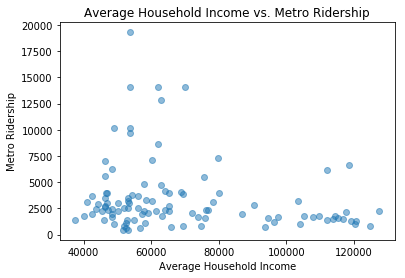

In [0]:
blue_line_dict = line_ridership_list_aggregated[0]
stations = []
stations_avg_household_income = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
  #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    household_income_sum = 0
    nearby_tracts = getNearbyCensusTracts(lat,long)

    avg_household_incomes = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))

        income = (census_tract_data[tract_num_key]['SE_A14008_001']).strip()
        if income:
          avg_household_incomes.append(float(income))  
  #       print("IN:",income)

    new_avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

    stations.append(station)
    stations_avg_household_income.append(new_avg_household_income)
    stations_ridership.append(value['daily_boardings'])
  
# Visualizing the relationship between average household income with ridership
plt.scatter(stations_avg_household_income, stations_ridership, alpha=0.5)
plt.title('Average Household Income vs. Metro Ridership')
plt.xlabel('Average Household Income')
plt.ylabel('Metro Ridership')
plt.show()

## Traffic Count

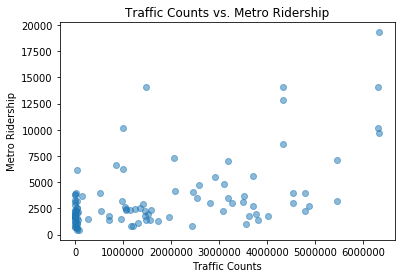

In [0]:
stations = []
stations_traffic_count = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
    (lat, long) = (value["lat"], value["lon"])

    nearby_intersections = getNearbyTrafficIntersections(lat,long)

    traffic_counts = 0

    for intersection in nearby_intersections:
        if not math.isnan(intersection):
          traffic_counts += (intersection)
        #  print("cnt:",traffic_counts)

    stations.append(station)   
    stations_traffic_count.append(traffic_counts)
    stations_ridership.append(value['daily_boardings'])
  
# Visualizing the relationship between average household income with ridership
plt.scatter(stations_traffic_count, stations_ridership, alpha=0.5)
plt.title('Traffic Counts vs. Metro Ridership')
plt.xlabel('Traffic Counts')
plt.ylabel('Metro Ridership')
plt.show()
  


## Population Density

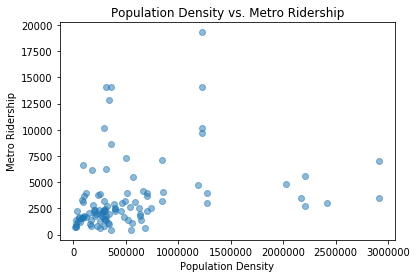

In [0]:
blue_line_dict = line_ridership_list_aggregated[0]
stations = []
stations_total_pop_densities = []
stations_ridership = []

for line_dict in line_ridership_list_aggregated:
  for station, value in line_dict.items():
  #   print(station)
    (lat, long) = (value["lat"], value["lon"])

    nearby_tracts = getNearbyCensusTracts(lat,long)

    pop_densities = []

    for tract in nearby_tracts:
        tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))

        pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
        pop_densities.append(pop_density)

    total_pop_densities = sum(pop_densities)
  #   print(station)
  #   print(total_pop_densities)

    stations.append(station)
    stations_total_pop_densities.append(total_pop_densities)
    stations_ridership.append(value['daily_boardings'])
  
# Visualizing the relationship between average household income with ridership

plt.scatter(stations_total_pop_densities, stations_ridership, alpha=0.5)
plt.title('Population Density vs. Metro Ridership')
plt.xlabel('Population Density')
plt.ylabel('Metro Ridership')
plt.show()

# Creating Training Dataset

For each metro station, we draw a 2 mile radius: within that radius, we find which census tract belongs to that station and average the household income data and population density data, and also the number of traffic counts that's inside the tract. 

In [0]:
x_train = []
y_train = []
x_stations = []
for line_ridership_dict in line_ridership_list_aggregated:
  for station, value in line_ridership_dict.items():
    print(station)
    num_census_tracts = 0
    household_income_sum = 0
    population_density_sum = 0
    traffic_sum = 0
    (lat, long) = (value["lat"], value["lon"])
    print(lat, long)
    x_stations.append(station)

    nearby_tracts = getNearbyCensusTracts(lat,long)

    pop_densities = list()
    avg_household_incomes = list()



    for tract in nearby_tracts:
      tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
      #print("NUM: ", tract_num_key)

      pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
      pop_densities.append(pop_density)
      #print("PD:",pop_density)

      income = (census_tract_data[tract_num_key]['SE_A14008_001']).strip()
      if income:
        avg_household_incomes.append(float(income))  
      #print("IN:",income)


    pop_density = sum(pop_densities)
    avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)

    x_train.append([avg_pop_density,avg_household_income])
    #print("avgPD:",avg_pop_density, " avgHI:",avg_household_income)
    
    daily_boarding = value['daily_boardings']
    y_train.append(daily_boarding)
  
  

## Testing data: Purple Line

In [0]:
x_test = []
y_test = []
x_test_stations = []

purple_ridership_df = pd.read_excel("RailActivityByStationFY2017.xlsx", sheet_name="Purple Line")

invalid_row_indicies = []
purple_ridership_aggregated = {}
for i in range(len(purple_ridership_df.index)):
  daily_boardings = purple_ridership_df.loc[i]['Average_Daily_Boardings']
  daytype = purple_ridership_df.loc[i]['Daytype']

  if type(purple_ridership_df.loc[i]['Station']) is not str:
    invalid_row_indicies.append(i)

  elif daily_boardings == 0 or isnan(daily_boardings):
    invalid_row_indicies.append(i)

  elif daytype != "Weekday":
    invalid_row_indicies.append(i)
    
  else:
    station = purple_ridership_df.loc[i]['Station']
    lat = purple_ridership_df.loc[i]['Latitude']
    lon = purple_ridership_df.loc[i]['Longitude']

    if station in purple_ridership_aggregated:
      purple_ridership_aggregated[station]['daily_boardings'] += daily_boardings

    else:
      value = {'daily_boardings': daily_boardings, 'lat': lat, 'lon': lon}
      purple_ridership_aggregated[station] = value

purple_ridership_df.drop(invalid_row_indicies, inplace=True)

  
# Purple Line
for station, value in purple_ridership_aggregated.items():
  print(station)
  num_census_tracts = 0
  household_income_sum = 0
  population_density_sum = 0
  traffic_sum = 0
  (lat, long) = (value["lat"], value["lon"])
  print(lat, long)
  x_test_stations.append(station)
  
  nearby_tracts = getNearbyCensusTracts(lat,long)
  
  pop_densities = list()
  avg_household_incomes = list()
  
                                                                                                                                                                              

  for tract in nearby_tracts:
    tract_num_key = '"{}"'.format(str(tract["properties"]["TRACTCE"]))
    #print("NUM: ", tract_num_key)
    
    pop_density = float(census_tract_data[tract_num_key]['SE_A00002_002'])
    pop_densities.append(pop_density)
    #print("PD:",pop_density)
    
    income = (census_tract_data[tract_num_key]['SE_A14008_001']).strip()
    if income:
      avg_household_incomes.append(float(income))  
    #print("IN:",income)
    
   
    
    
  avg_pop_density = sum(pop_densities)
  avg_household_income = sum(avg_household_incomes)/len(avg_household_incomes)
  
  x_test.append([avg_pop_density,avg_household_income])
    #print("avgPD:",avg_pop_density, " avgHI:",avg_household_income)
  
  y_test.append(value['daily_boardings'])


x_test = np.array(x_test)
y_test = np.array(y_test)


Wilshire / Western Station
34.061689 -118.308756
Wilshire / Normandie Station
34.061753 -118.301458
Wilshire / Vermont Station
34.062701 -118.290082
Westlake / MacArthur Park Station
34.056368 -118.274879
7th Street / Metro Center Station - Metro Red & Purple Lines
34.048634 -118.258682
Pershing Square Station
34.049316 -118.251259
Civic Center / Grand Park Station
34.0549 -118.246057
Union Station - Metro Red & Purple Lines
34.056197 -118.234249


## Creating Machine Learning Model

Import Python packages for Linear Regression and XG Boost

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import metrics
import xgboost as xgb

In [0]:
np.set_printoptions(threshold=sys.maxsize)

print(x_train)
#x_train.shape
#y_train.reshape(405,1)
#y_train.shape

[[29238.701470588236, 53234.892841509274], [29388.740789473686, 52617.638260478205], [27514.422407407408, 53021.521846850104], [26298.56766666667, 52093.43382300369], [16160.191, 69568.18200511091], [8624.8327, 94622.56741498929], [11642.345375, 78435.17166345842], [11140.410375, 58598.4565150056], [15042.7933125, 54370.71113125301], [17333.113529411763, 48972.55929493185], [19319.8101, 44329.34602709424], [20060.727407407412, 46198.02488332338], [19599.82861538462, 46640.16803471407], [20725.279090909098, 45401.77703090721], [21933.899444444447, 43592.01462044609], [19514.826624999998, 46078.57329244295], [19733.5508, 50080.70930911324], [24191.870827586208, 42591.39297306848], [37399.38397058824, 46794.6542592005], [36108.21747058823, 53594.08544744862], [29810.713695652175, 52659.27886543408], [29262.725000000002, 53196.99837707773], [15848.587699999998, 69984.26568707424], [9420.261799999998, 118538.61357691807], [20995.293541666666, 79901.80765059583], [22774.433960000002, 75731.7

Instantiating the model and training the model

Linear Regression r^2: -1.1001916391721407
MSE r^2: 14657604.106266294
8


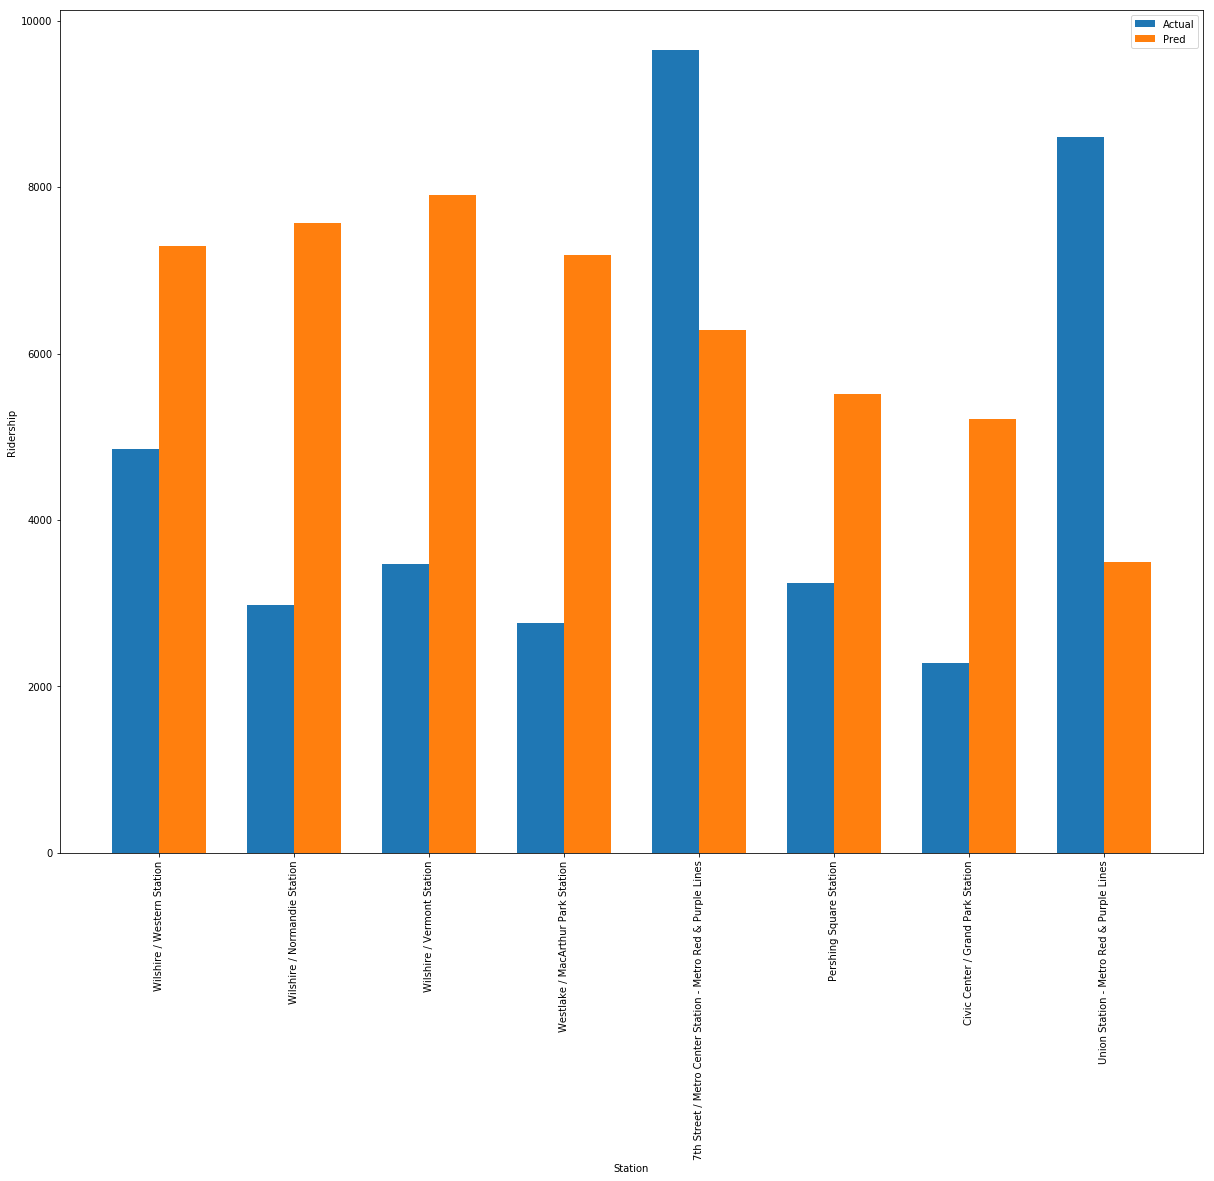

svr rbf r^2: 0.020305695887381958
MSE r^2: 6837457.585778821


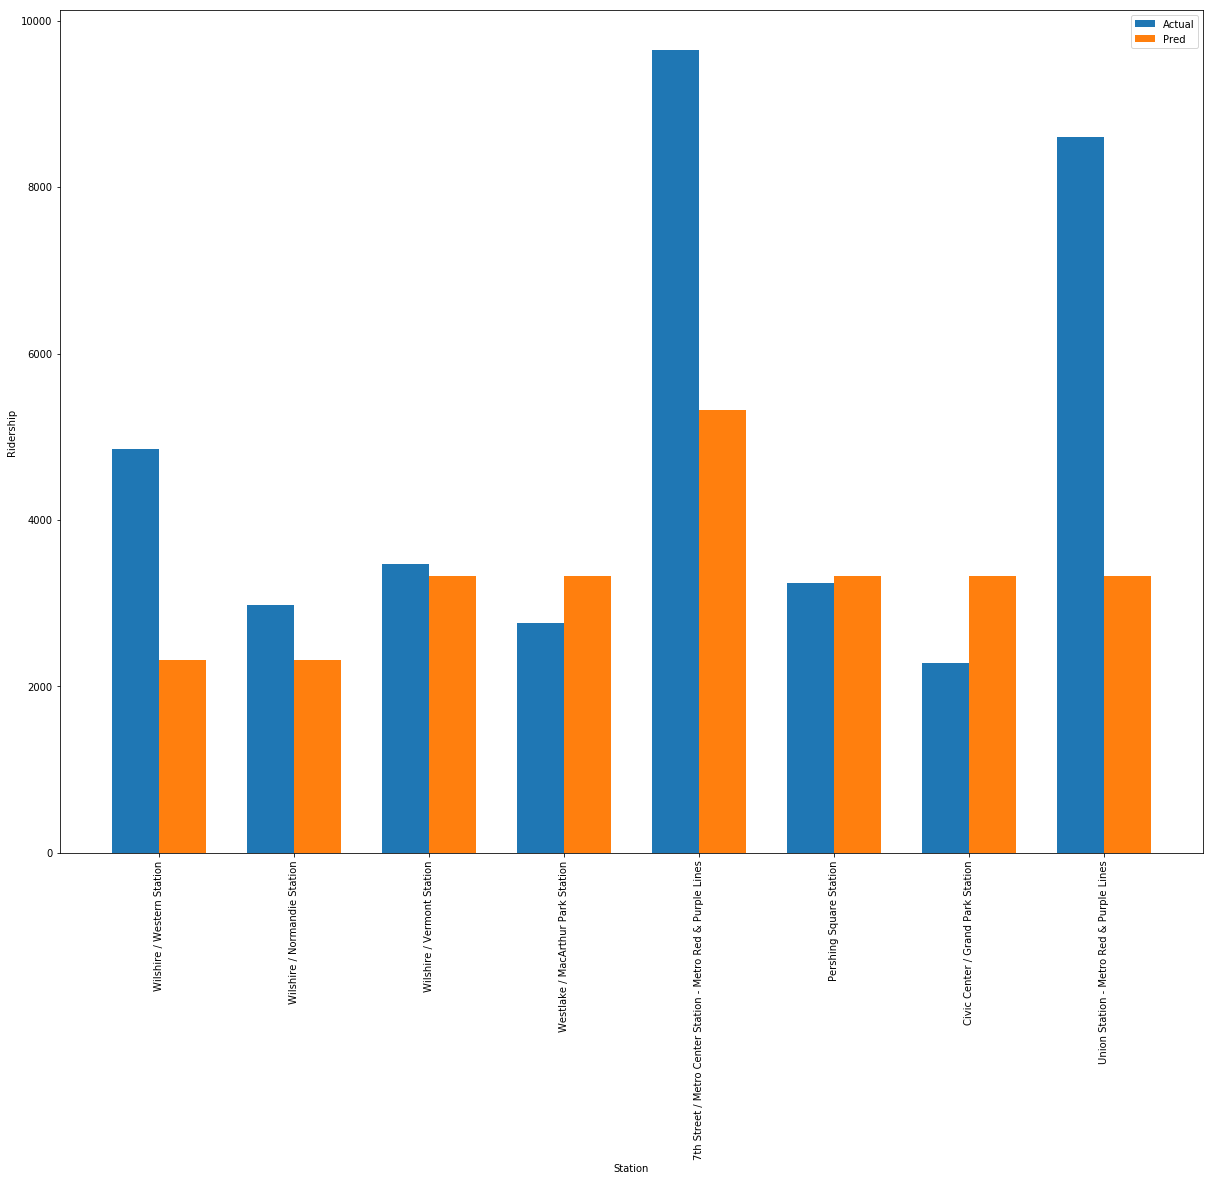

XGBoost r^2: -0.5282739000464731
MSE r^2: 10666090.358140275


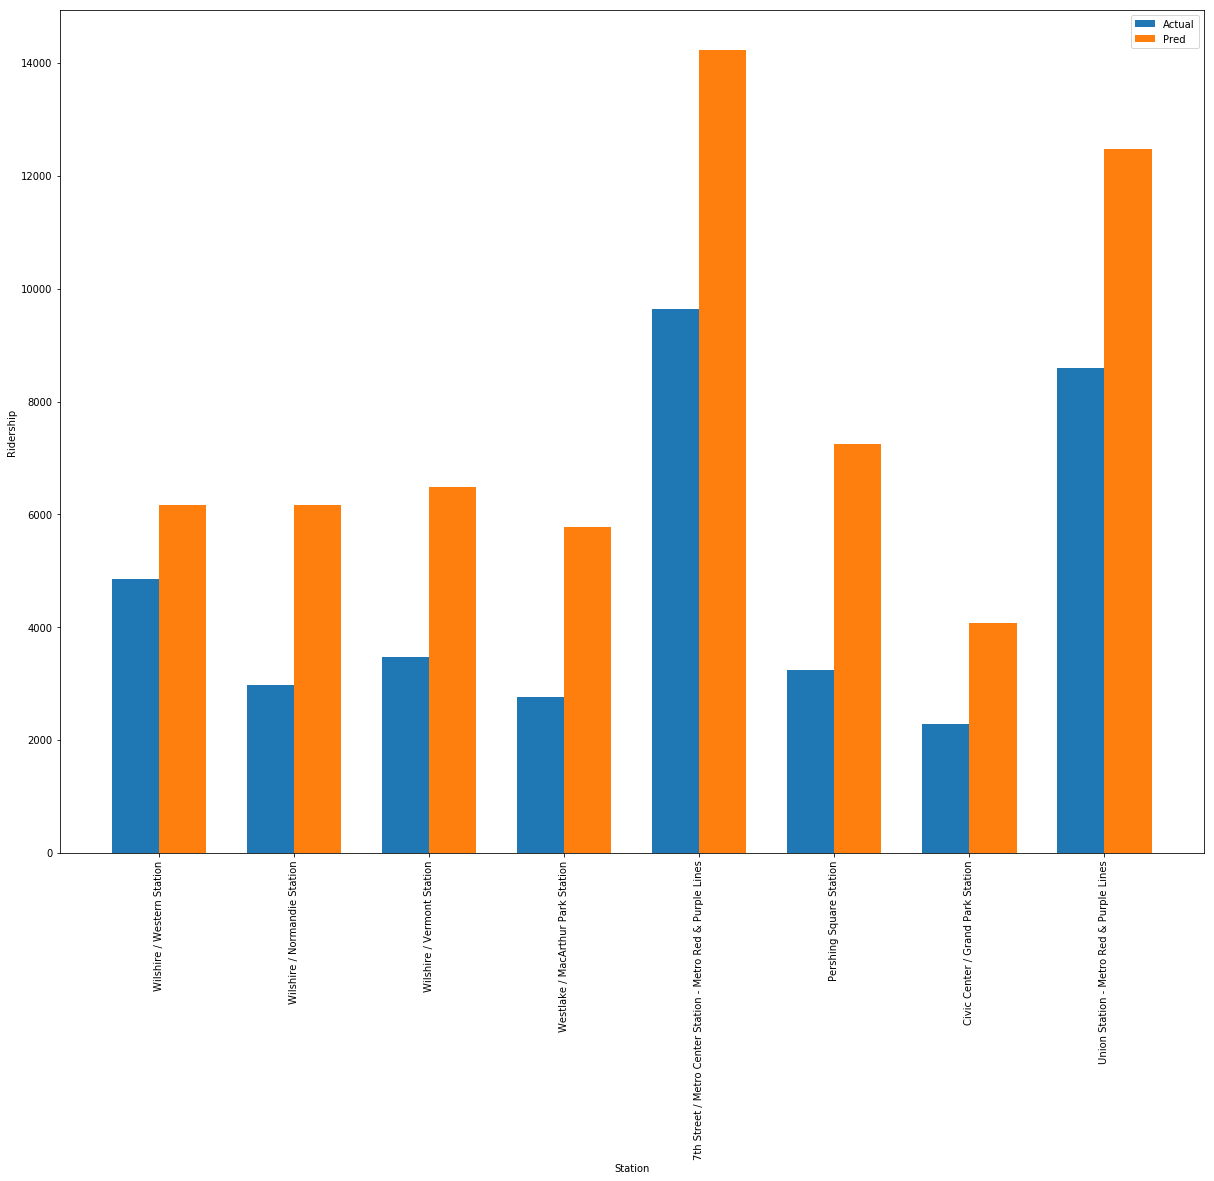

In [0]:


# Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
 
print("Linear Regression r^2:",metrics.r2_score(y_test, y_pred))
print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))


fig, ax = plt.subplots()

index = np.arange(len(x_test_stations))
print(len(index))
bar_width=0.35

rects1 = ax.bar(index, y_test,  bar_width, label='Actual')
rects2 = ax.bar(index +  bar_width, y_pred,  bar_width, label='Pred')

ax.set_xlabel('Station')
ax.set_ylabel('Ridership')
ax.set_xticks(index+bar_width/2)
x_labels = []
for index, row in purple_ridership_df.iterrows():
  x_labels.append(row['Station'])
ax.set_xticklabels(x_labels, minor=False, rotation="vertical")
ax.legend()

fig.set_size_inches(10.5, 7.5)
plt.show()

# Support Vector Regression
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

svr_rbf.fit(x_train,y_train)
y_pred = svr_rbf.predict(x_test)
print("svr rbf r^2:",metrics.r2_score(y_test, y_pred))
print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots()

index = np.arange(len(x_test_stations))
bar_width=0.35

rects1 = ax.bar(index, y_test,  bar_width, label='Actual')
rects2 = ax.bar(index +  bar_width, y_pred,  bar_width, label='Pred')

ax.set_xlabel('Station')
ax.set_ylabel('Ridership')
ax.set_xticks(index+bar_width/2)
x_labels = []
for index, row in purple_ridership_df.iterrows():
  x_labels.append(row['Station'])
ax.set_xticklabels(x_labels, minor=False, rotation="vertical")
ax.legend()

fig.set_size_inches(20.5, 15.5)
plt.show()
'''
svr_lin.fit(x_train,y_train)
y_pred = svr_lin.predict(x_test)
print("svr lin r^2:",metrics.r2_score(y_test, y_pred))

svr_poly.fit(x_train,y_train)
y_pred = svr_poly.predict(x_test)
print("svr poly r^2:",metrics.r2_score(y_test, y_pred))
'''
# XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
print("XGBoost r^2:",metrics.r2_score(y_test, y_pred))
print("MSE r^2:",metrics.mean_squared_error(y_test, y_pred))


fig, ax = plt.subplots()

index = np.arange(len(x_test_stations))
bar_width=0.35

rects1 = ax.bar(index, y_test,  bar_width, label='Actual')
rects2 = ax.bar(index +  bar_width, y_pred,  bar_width, label='Pred')

ax.set_xlabel('Station')
ax.set_ylabel('Ridership')
ax.set_xticks(index+bar_width/2)
x_labels = []
for index, row in purple_ridership_df.iterrows():
  x_labels.append(row['Station'])
ax.set_xticklabels(x_labels, minor=False, rotation="vertical")
ax.legend()

fig.set_size_inches(20.5, 15.5)
plt.show()
